# Stock market analysis on Siemens Healthineers AG stocks

In this jupyter notebook, I have analyzed Siemens Healthineers stock market data including the change in stock price, daily average return, moving average, and predict future stock behavior of the stocks using LSTM.

In [1]:
# Installing dependencies
!pip install pandas numpy mplfinance yfinance pandas_datareader matplotlib seaborn statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Override the pandas_datareader’s default with Yahoo Finance API
yf.pdr_override()

# Fetch stock data for Siemens Healthineers AG
symbol = 'SHL.DE'
end = datetime.now()
start_date = datetime(end.year - 1, end.month, end.day)
shl_stocks = pdr.get_data_yahoo(symbol, start=start_date, end=end)

shl_stocks.head(5)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-15,51.099998,51.480000,50.840000,51.320000,50.369999,516771
2023-02-16,50.480000,50.939999,49.950001,50.240002,50.240002,603292
2023-02-17,49.860001,50.419998,49.160000,50.320000,50.320000,660877
2023-02-20,50.419998,50.880001,50.299999,50.639999,50.639999,301088
2023-02-21,50.500000,50.740002,49.810001,50.279999,50.279999,351357


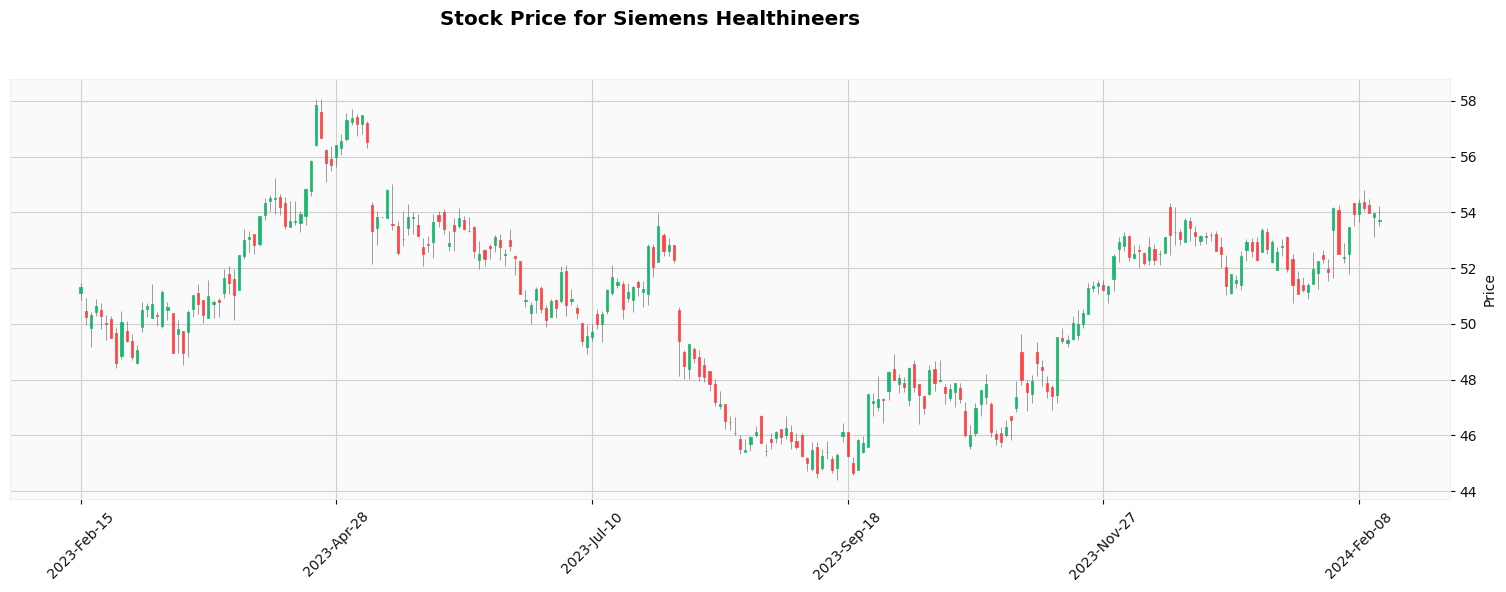

In [3]:
# Prepare the data for candlestick chart
shl_stocks.index.name = 'Date'
shl_stocks.reset_index(inplace=True)
shl_stocks['Date'] = pd.to_datetime(shl_stocks['Date'])
shl_stocks.set_index('Date', inplace=True)


# Create the candlestick chart
mpf.plot(shl_stocks,
          type='candle',
          title=f'Stock Price for Siemens Healthineers',
          ylabel='Price',
          style='yahoo',
          figsize=(20,6),
          returnfig=True)
mpf.show()

## 1. Descriptive Statistics about the Data
`.describe()` generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding `NaN` values.

Analyzes both numeric and object series, as well as `DataFrame` column sets of mixed data types. The output will vary depending on what is provided.

In [4]:
# Summary Stats
shl_stocks.describe()

,Open,High,Low,Close,Adj Close,Volume
count,255.000000,255.000000,255.000000,255.000000,255.000000,2.550000e+02
mean,50.712941,51.156510,50.232863,50.728824,50.725098,6.887553e+05
std,2.977618,2.993563,2.964222,3.002300,3.002153,3.505367e+05
min,44.750000,45.220001,44.389999,44.639999,44.639999,0.000000e+00
25%,48.390001,48.720001,47.700001,48.119999,48.119999,4.865750e+05
50%,51.099998,51.520000,50.680000,51.200001,51.200001,6.048150e+05
75%,52.929998,53.299999,52.459999,52.929998,52.929998,7.707455e+05
max,57.599998,58.080002,57.139999,57.840000,57.840000,2.939339e+06


## Information About the Data
`.info()` method prints information about a DataFrame including the `index`, `dtype` and columns, `non-null` values, and `memory usage`.

In [5]:
# General info
shl_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2023-02-15 to 2024-02-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       255 non-null    float64
 1   High       255 non-null    float64
 2   Low        255 non-null    float64
 3   Close      255 non-null    float64
 4   Adj Close  255 non-null    float64
 5   Volume     255 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.9 KB


In [6]:
len(shl_stocks)

255

We have only 255 records in one year because weekends are not included in the data.

## Closing Price

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

[Text(0.5, 1.0, 'Closing Stocks Price of Siemens Healthineers'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Adj Close')]

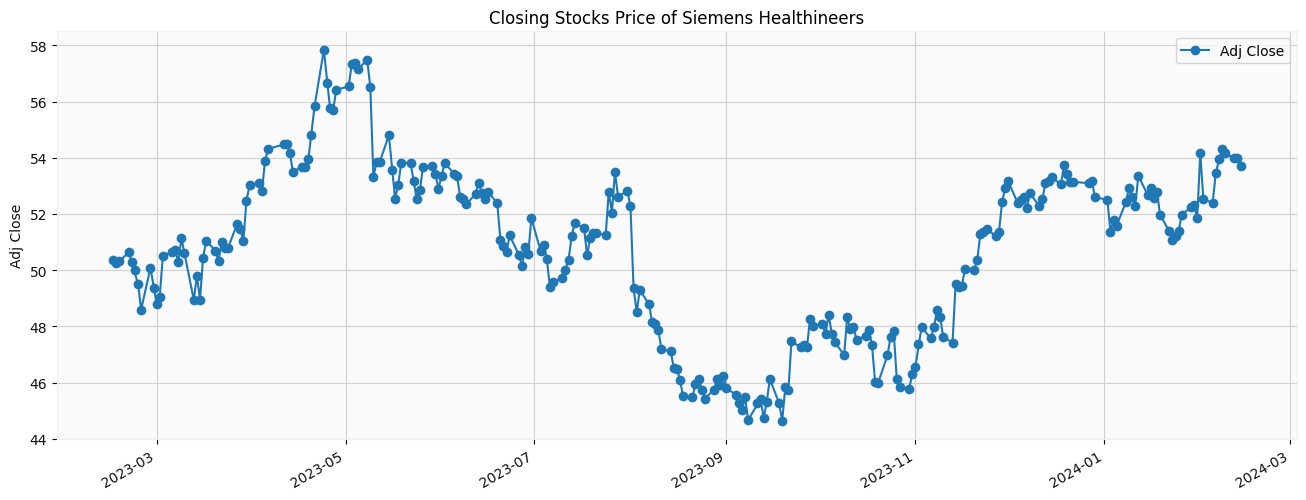

In [7]:
# Historical view of the closing price
shl_stocks['Adj Close'].plot(figsize=(16, 6), legend=True, marker='o').set(
    title="Closing Stocks Price of Siemens Healthineers",
    xlabel=None,
    ylabel='Adj Close'
)

## Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

[Text(0.5, 1.0, 'Sales Volume for Siemens Healthineers'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Volume')]

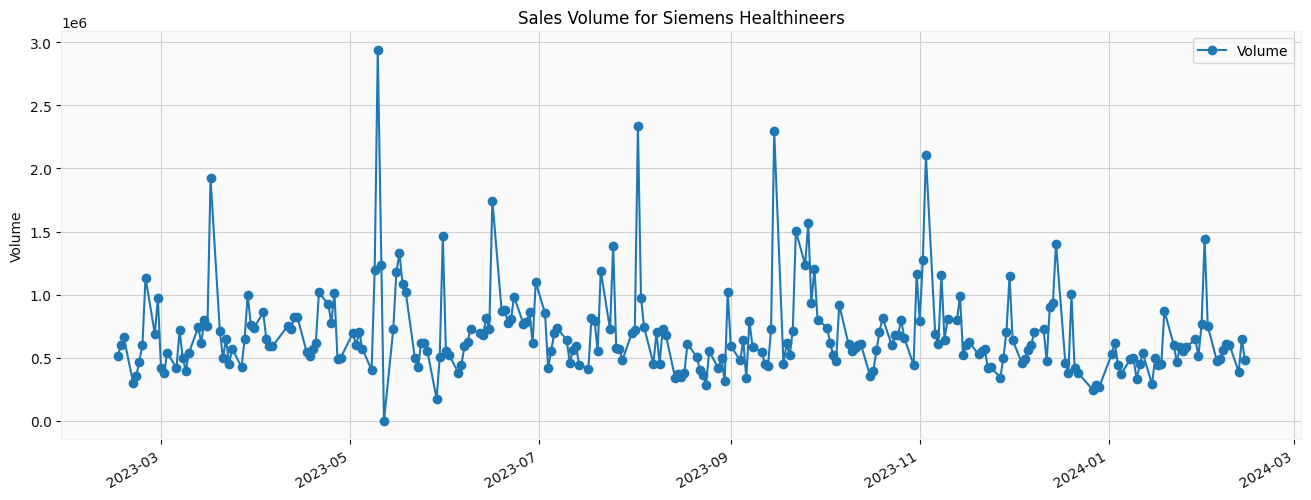

In [8]:
# Now let's plot the total volume of stock being traded each day
shl_stocks['Volume'].plot(figsize=(16, 6), legend=True, marker='o').set(
    title="Sales Volume for Siemens Healthineers", xlabel=None, ylabel='Volume'
)

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

## 2. What was the moving average of the various stocks?

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

In [9]:
# Window 10, 20, and 50
ma_day = [10, 20, 50]
for ma in ma_day:
  column_name = f"MA for {ma} days"
  shl_stocks[column_name] = shl_stocks['Adj Close'].rolling(ma).mean()

ic = [
    mpf.make_addplot(shl_stocks['MA for 10 days'],color = '#AA1849',panel=0,),
    mpf.make_addplot(shl_stocks['MA for 20 days'],color = '#ff6600',panel=0,),
    mpf.make_addplot(shl_stocks['MA for 50 days'],color = '#3333cc',panel=0,),
]
shl_stocks.tail(5)

,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,,,
2024-02-08,53.939999,54.459999,53.660000,54.320000,54.320000,604815,52.922,52.528,52.6036
2024-02-09,54.380001,54.799999,54.060001,54.160000,54.160000,604110,53.140,52.568,52.6596
2024-02-12,54.279999,54.480000,53.980000,53.980000,53.980000,386615,53.312,52.633,52.6908
2024-02-13,53.820000,53.980000,53.119999,53.980000,53.980000,651585,53.478,52.686,52.7116
2024-02-14,53.700001,54.220001,53.520000,53.720001,53.720001,479137,53.664,52.743,52.7228


(<Figure size 2000x600 with 2 Axes>, [<Axes: ylabel='Price'>, <Axes: >])

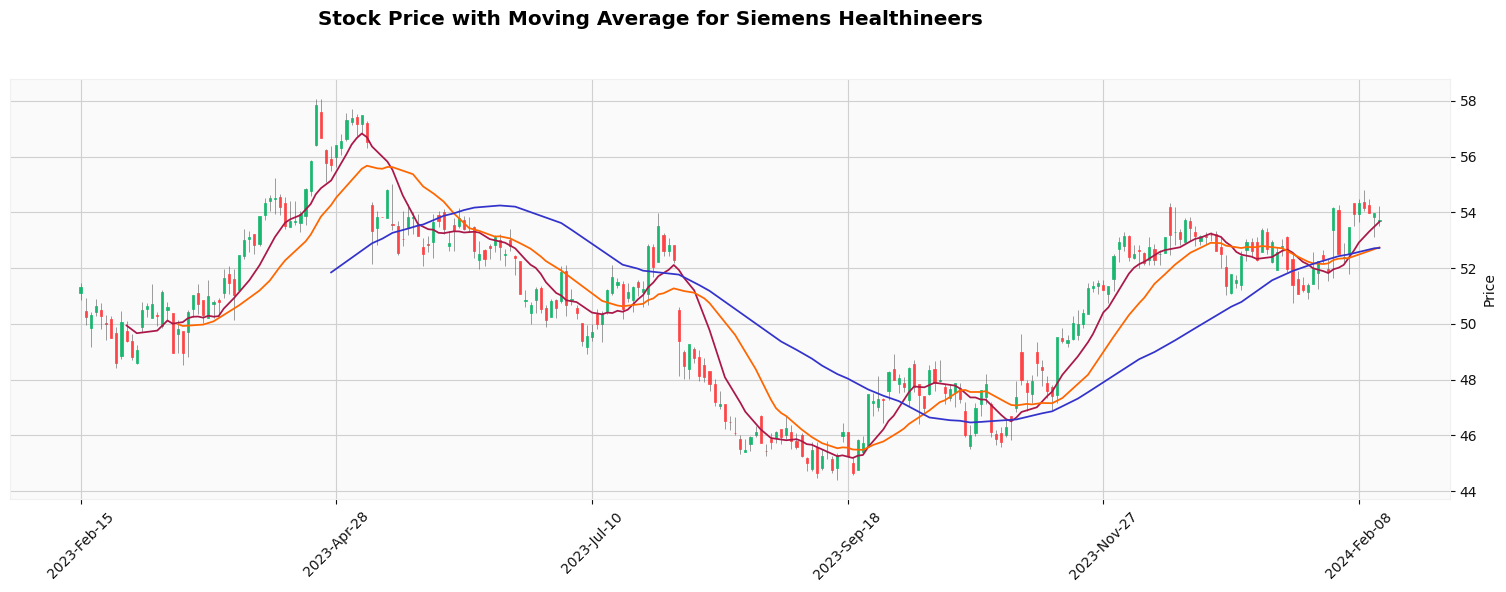

In [10]:
# Create the candlestick chart with moving average
mpf.plot(shl_stocks,
          type='candle',
          title='Stock Price with Moving Average for Siemens Healthineers',
          ylabel='Price',
          style='yahoo',
          addplot = ic,
          figsize=(20, 6),
          returnfig=True)

We see in the graph that the best values to measure the moving average are 10 and 20 days because we still capture trends in the data without noise.

## 3. What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value.

[Text(0.5, 1.0, 'Daily Return for shl_stocks'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Daily Return')]

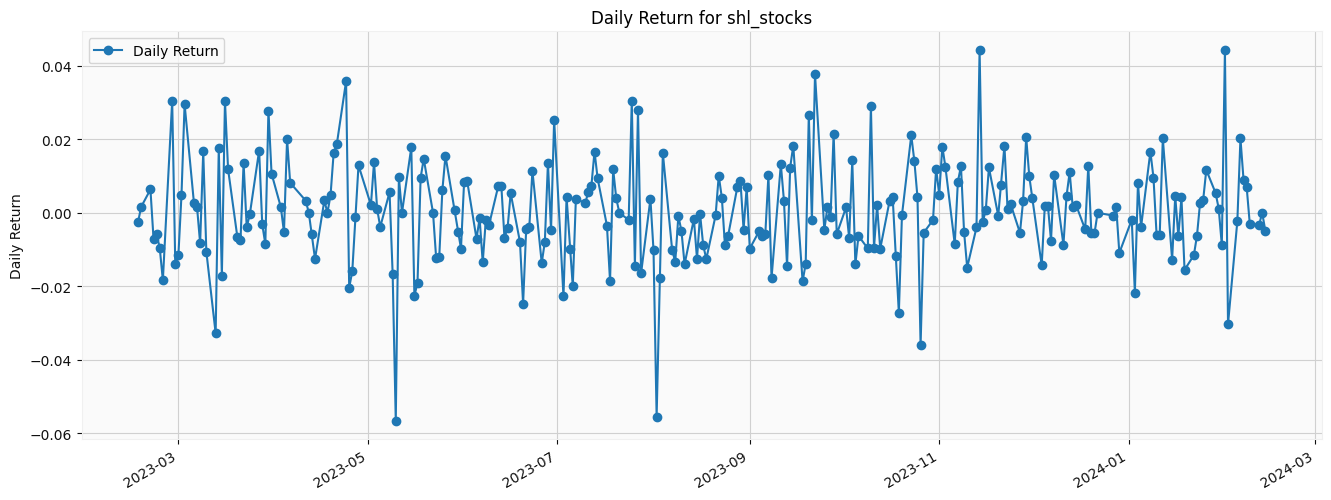

In [11]:
shl_stocks['Daily Return'] = shl_stocks['Adj Close'].pct_change()
shl_stocks['Daily Return'].plot(figsize=(16, 6), legend=True, marker='o').set(
    title="Daily Return for shl_stocks", xlabel=None, ylabel='Daily Return'
    )

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create a histogram with 50 bins.

[Text(0.5, 0, 'Daily Return'),
 Text(0, 0.5, 'Counts'),
 Text(0.5, 1.0, 'SHL Stocks')]

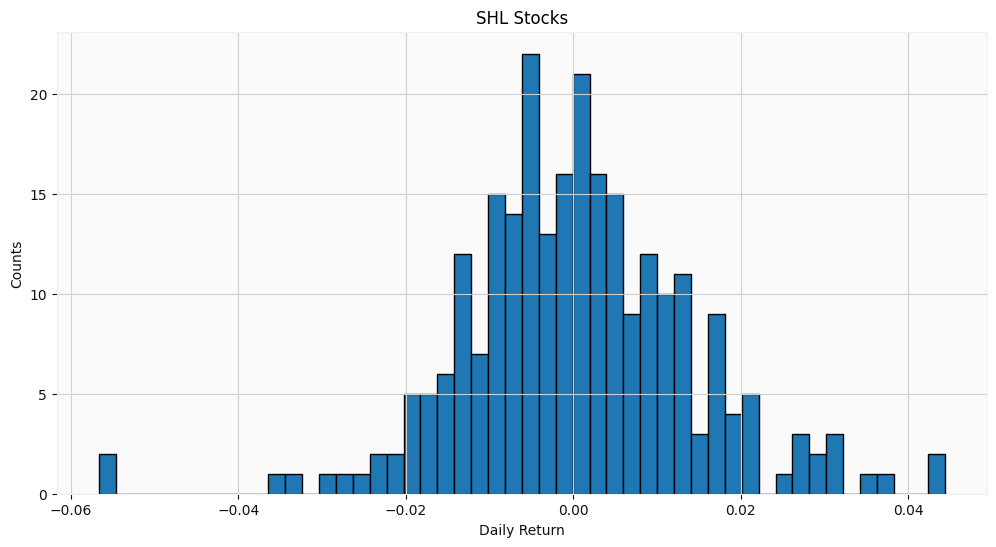

In [12]:
shl_stocks['Daily Return'].hist(figsize=(12, 6), bins=50, edgecolor='black').set(
    xlabel='Daily Return',
    ylabel='Counts',
    title='SHL Stocks'
)

## 4. Predicting the closing stock price of Siemens Healthineers:

In [13]:
# Get the stock quote
#Doing this for 5 Years stock data
end = datetime.now()
start_date = datetime(end.year - 5, end.month, end.day)
df = pdr.get_data_yahoo(symbol, start = start_date, end = end)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-15,35.014999,35.755001,34.875000,35.650002,33.238373,586935
2019-02-18,35.544998,35.665001,35.325001,35.520000,33.117165,283037
2019-02-19,35.424999,35.875000,35.240002,35.875000,33.448147,499960
2019-02-20,35.945000,36.355000,35.889999,36.285000,33.830410,592005
2019-02-21,36.349998,36.494999,35.974998,36.169998,33.723194,541989
...,...,...,...,...,...,...
2024-02-08,53.939999,54.459999,53.660000,54.320000,54.320000,604815
2024-02-09,54.380001,54.799999,54.060001,54.160000,54.160000,604110
2024-02-12,54.279999,54.480000,53.980000,53.980000,53.980000,386615


[Text(0.5, 1.0, 'Close Price History'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Close Price USD ($)')]

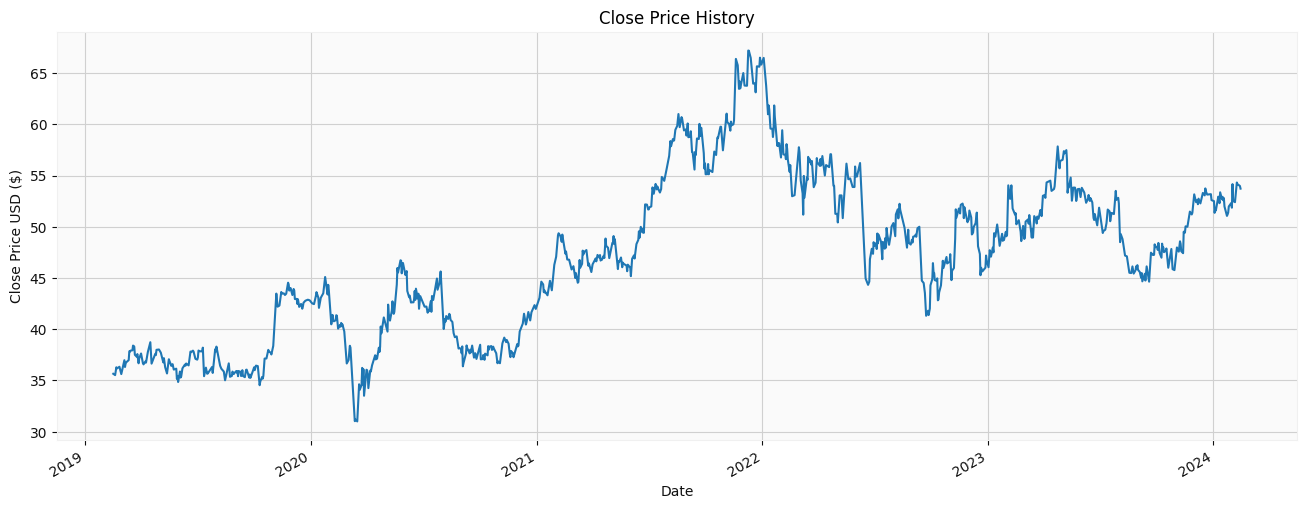

In [14]:
df['Close'].plot(figsize=(16, 6)).set(title='Close Price History', xlabel='Date', ylabel='Close Price USD ($)')

In [15]:
dataset = df.filter(['Close']).values
training_data_len = int(np.ceil( len(dataset) * .95 ))
print(training_data_len)
print(len(df.filter(['Close'])))

1209
1272


In [16]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
len(scaled_data)

1272

In [17]:
# Create the training data set
train_data = scaled_data[:training_data_len, 0]

x_train, y_train = [], []

for i in range(60, len(train_data)):
    #1. x_train -> 0 to 59, y = 60
    # x_train and y_train -> append
    #2. x_train -> 0 to 59, 1 to 60 y = 60, 61
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
# Reshape the data
# x_train.shape[0]: This retrieves the number of sequences in x_train.
# x_train.shape[1]: This retrieves the length of each sequence in x_train.
# x_train.shape[2]: This would be 1, representing a single feature per time step.

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)

(1149, 60, 1)


In [18]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=12, epochs=50)

Epoch 1/50
96/96 [==============================] - 17s 21ms/step - loss: 0.0111
Epoch 2/50
96/96 [==============================] - 3s 29ms/step - loss: 0.0031
Epoch 3/50
96/96 [==============================] - 3s 30ms/step - loss: 0.0027
Epoch 4/50
96/96 [==============================] - 2s 23ms/step - loss: 0.0024
Epoch 5/50
96/96 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 6/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 7/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 8/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 9/50
96/96 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 10/50
96/96 [==============================] - 2s 16ms/step - loss: 0.0010
Epoch 11/50
96/96 [==============================] - 1s 15ms/step - loss: 9.8421e-04
Epoch 12/50
96/96 [==============================] - 1s 12ms/step - loss: 9.5142e-04
Epoch 13/50
96/96 [=========

In [19]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]
print(f'Length of training_data:  {training_data_len}')
print(f'Length of testing data: {len(test_data)}')

# Create the data sets x_test and y_test
x_test = np.array([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = dataset[training_data_len:, :]

# Reshape the data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = scaler.inverse_transform(model.predict(x_test))

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

Length of training_data:  1209
Length of testing data: 123
2/2 [==============================] - 1s 9ms/step


0.5892725168617381

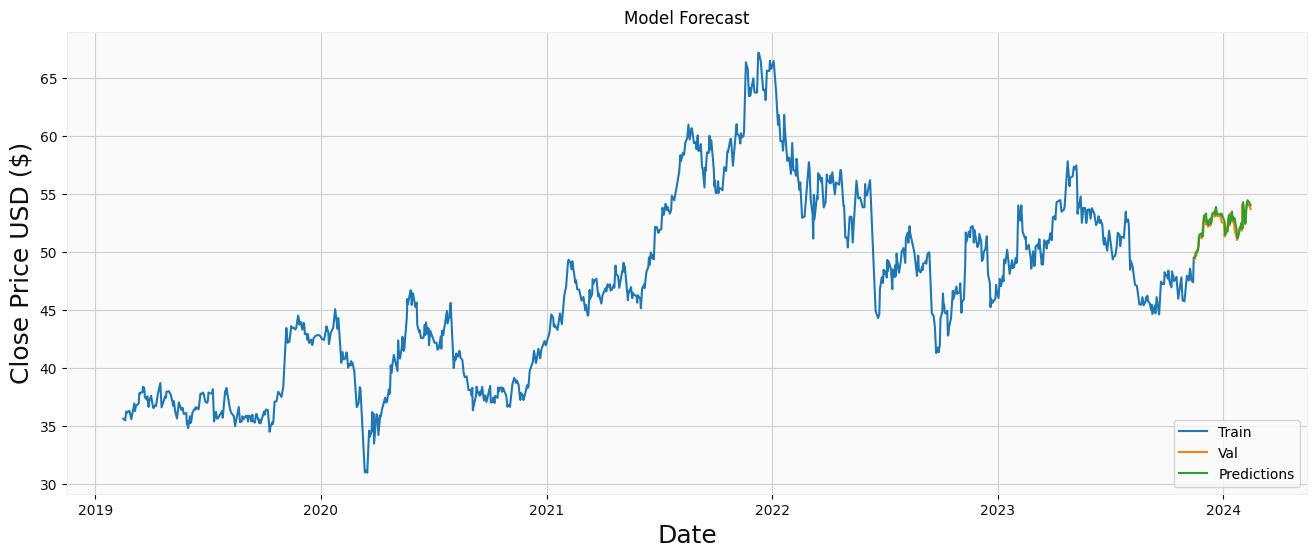

In [20]:
# Plot the data
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<Axes: title={'center': 'Close'}, xlabel='Date'>

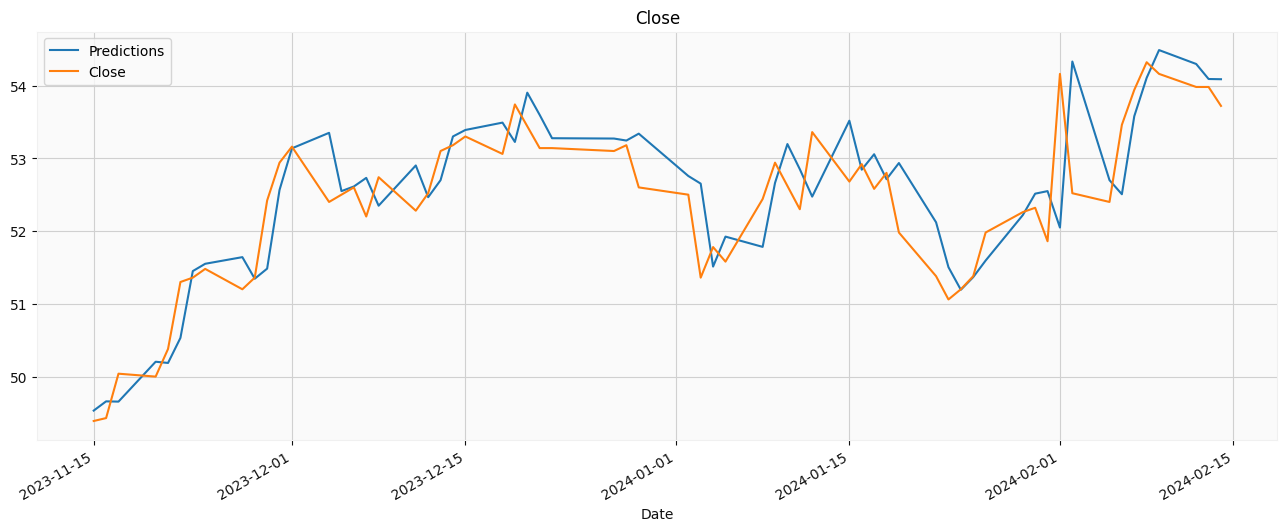

In [21]:
# Show the valid and predicted prices graph
valid['Predictions'].plot(kind='line', figsize=(16, 6), title='Predictions', legend=True)
valid['Close'].plot(kind='line', figsize=(16, 6), title='Close', legend=True)

### Prediction for Next 30 days

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

end = datetime.now()
start_date = datetime(end.year - 5, end.month, end.day)
df = pdr.get_data_yahoo(symbol, start = start_date, end = end)

# Fit the MinMaxScaler on the historical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.filter(['Close']).values)

future = df.filter(['Close']).values

for _ in range(30):
    future_scaled = scaler.transform(future)
    future_test = np.array(future_scaled[-1000:]).reshape(1, 1000, 1)
    predictions_scaled = model.predict(future_test, verbose=0)
    predictions = scaler.inverse_transform(predictions_scaled)
    future = np.append(future, predictions, axis=0)

[*********************100%%**********************]  1 of 1 completed


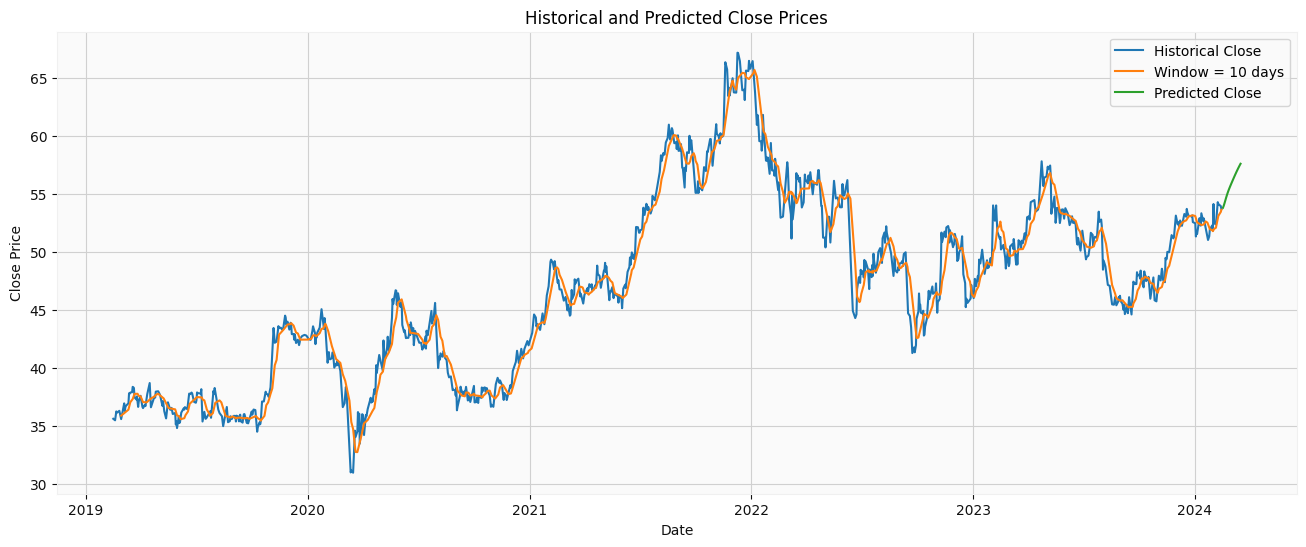

In [23]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Historical Close')
df['MA 10 days'] = df['Close'].rolling(window=10).mean()
plt.plot(df['MA 10 days'], label='Window = 10 days')

plt.plot(pd.date_range(start=end + pd.DateOffset(days=1), periods=30), future[-30:], label='Predicted Close')


plt.title('Historical and Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()